This notebook contains all my notes from Udacity Course [Artificial Intelligence for Robotics](https://www.udacity.com/course/artificial-intelligence-for-robotics--cs373).  I have learned a lots of fundamental concept of autonomous driving from this course and I am thankful to Udacity for that.

## Localization

Localization is the process, how a robot identify its location in an environment. A robot does this using probability theory. Initially the robot does not know where it is, so the probability of being in any place will be the same. In localization, basically we try to change these probabilities with the measurement of the robot such as the probability of one place increases whereas probability of other places decreases. The location with highest probability is the location of the robot and thus our robot will localize itself in the environment. 

##### steps in localization are:

   1. Initialize all the locations with uniform probability distribution, which is called prior belief.
   2. sense the world and change our prior belief according to the sense, which is called posterior belief. To change our prior we have to multiply it with the factor of the sense being correct or wrong. Further we have to normalize this to make it a valid probability distribution.   
   3. Take an action and change the posterior belief according to the action taken, which is called convolution. 
   4. sense the world again and now changing our prior belief from previous step will do the trick, now our posterior belief will be something meaningfull. Only one location will have the highest probability. So thus our robot will localize itself. 

To understand it, lets assume a robot in one dimensional discrete world. We can define the location of this world with different colors and our robot can sense these colors. Now we will try to apply the above algorithm on this robot and lets whether our robot can localize itself or not:

In [9]:
# one dimensional world
world = ['red', 'green', 'green','red', 'red', 'green']
# step 1: Initializing all the locations with uniform probability
p = [1/len(world) for _ in range(len(world))]
# These are the factor of being the sense correct or not 
pHit = 0.6 
pMiss = 0.2

# These are the valid action the robot can take
action = [0,1] #0 means move left and 1 means move right

# we will do step 2 as a function because we have to do it repeatedly.
def sense(sense, prior):
    '''This function can calculate posterior probability given the sense and prior'''
    posterior = [0.0 for _ in range(len(prior))]
#     chaning prior according to the factor
    for i in range(len(prior)):
        if sense==world[i]:
            posterior[i] = prior[i] * pHit
        else:
            posterior[i] = prior[i] * pMiss
#     normalizing the posterior to make it a valid probability distribution
    posterior = [p/sum(posterior) for p in posterior]
    return posterior


# we will do step 3 as a function too, cause we have to do it repeatedly too. 
def convolution(action, posterior):
    '''This function will change the posterior according to the action taken by the robot.
    This function assumes the world to be a cyclic world that means the element falls off 
    from right will go to the left or vice versa'''
    new_prior = [0.0 for _ in range(len(posterior))]
#   robot moves to the left
    if action == 0:
        new_prior = [posterior[(i+1)%len(posterior)] for i in range(len(posterior))]
#     robot moves to the right
    else:
        new_prior = [posterior[(i-1)] for i in range(len(posterior))]
    return new_prior

# applying the algorithm
# step 2
posterior = sense('green',p)
# step 3
new_prior = convolution(1, posterior)
# step 2 repeated
new_posterior = sense('green',new_prior)
print(new_posterior)

[0.13636363636363638, 0.13636363636363638, 0.4090909090909091, 0.13636363636363638, 0.04545454545454547, 0.13636363636363638]


As we can see the highest probability is in location 2(starting from 0 location) which is correct according to our world setup, if we sense two times and green is the result for each time. So by applying the above algorithm our robot can actually localize itself in this one dimensional world.

### Inexact robot motion

So we have undersatnd the basic concepts of localization. But in our previous example we assume the robot to be in exact motion. Which means if the robot wants to go to right by one cell it does it correctly every time. This is not the case in real life. In reality, the robot motion is uncertain. 

So for example, lets say if we give the robot the command to move right by one cell, the robot remains in the current cell with probability of 0.1, it moves to the right cell with probability of 0.8, it can also overshoot the goal by one cell with probability of 0.1. 

Considering this uncertain robot motion, the new probability of a cell will be the addition of all the probabilities from cells those are candidate for the current cell.  

In [17]:
world=['green', 'red', 'red', 'green', 'green']
p = [1/len(world) for _ in range(len(world))]
measurements = ['red', 'green'] # considering multiple measrements
motions = [1, 1] # considering multiple motion
pHit = 0.6
pMiss = 0.2
# probability for inexact robot motion
pExact = 0.8 # probability for the correct move
pOvershoot = 0.1 # probability for overshooting the goal 
pUndershoot = 0.1 # probability for undershooting the goal

def sense(sense, prior):
    '''This function can calculate posterior probability given the sense and prior'''
    posterior = [0.0 for _ in range(len(prior))]
#     chaning prior according to the factor
    for i in range(len(prior)):
        if sense==world[i]:
            posterior[i] = prior[i] * pHit
        else:
            posterior[i] = prior[i] * pMiss
#     normalizing the posterior to make it a valid probability distribution
    posterior = [p/sum(posterior) for p in posterior]
    return posterior

def convolution(p, U):
    '''This function takes the posterior probability and steps to move in left or right.
    It returns new prior distribution. U=1 means move right by one cell, U=-1 means move left 
    by one cell. Assuming the world to be cyclic'''
    q = []
    for i in range(len(p)):
        s = pExact * p[(i-U) % len(p)] # calculating probability of correct motion
        s = s + pOvershoot * p[(i-U-1) % len(p)] # probability of overshoot motion
        s = s + pUndershoot * p[(i-U+1) % len(p)] # probability of undershoot motion
        q.append(s)
    return q

for i,s in enumerate(measurements):
    # step 2
    p = sense(s,p)
    # step 3
    p = convolution(p, motions[i])
print(p)

[0.21157894736842103, 0.1515789473684211, 0.08105263157894739, 0.16842105263157897, 0.3873684210526316]


So from the above output we can see that the probability distribution works in same way as previous but this time we consider the inexact robot motion. So this convolution function or move function is more accurate considering the real life scenario. 

### understand sense and move from probability theorem

If you look closely to the sense function it will lead us to the Bayesian rule. Lets represent the prior belief as X and the measurement as Z then the sense function is calculating the probability after having the measurement Z. In mathmatically we can say it like p(X|Z). We all know that according to the bayes theorem, 

    p(X|Z) = (p(Z|X) * P(X)) / p(Z)
    
Here p(Z|X) is the probability of having a measurement. In our case it is defined by pHit and pMiss. p(X) is the prior belief. p(Z) is just a normalized term. Since our final output is a posterior distribution we can replace p(Z) with just the normalization term. Thats the beauty of Bayes rule. So, 

    p(Z) = sum of p(Z|X) * P(X) for all the cells. 
    
Now the move or convolution function can be relate to something called total probability theory. The way we computed one cell probability after one move, was looking at all the grid cells from which it could have come from one time step earlier, we looked at the prior probability of those grid cells at previous time step and we multiply it with a probability that our motion command would carry us from those cells to this current cell. In probability term people write this like the follows-

    p(A) = sum over all B cells ( p(A|B) p(B) ) , here p(B) is the prior at previous time step , p(A|B) is probability of transition to this cell from B cells. 
    
Here A is the current cell index and B is the all possible previous cell's prior probabilities. This theorem is known as Theorem of total probability.  

The above procedure is called histogram based localization or monte carlo robot localization. Next we are going to learn about Kalman filters which is used for tracking other cars in the road. 

## Kalman Filters

So by using Localization techniques discussed above our robot can find itself in an environment. But for a safe driving we must know the location and velocity of other cars as well in the environment. Kalman filters help use to know the location of other cars in the environment. 

Though generally Kalman filters are being used to track other cars in the system, it is a similar approach as monte carlo localization. The differences are in Kalman filters, we try to estimate a continuous state (in simple word, we consider the world to be continuous instead of discrete grid cells) whereas in monte carlo localization we estimated a discrete state. As a result Kalman filters gives us unimodal distribution but monte carlo localization gives us multimodal distribution. 

Since we consider the state of the robot is now continuous we can represent the prior belief as a gaussian distribution. A gaussian distribution is parameterized by two variable. One is mean and the other is its variance. Since it is representing a probability distribution the area under the gaussian should be sums up to 1. The mean will represent the highest probability for the location. Here the larger the variance is for a distribution the less it is confidence about the probability. So after every measurements we will expect the variance will be very low and we will get a narrow gaussian distribution. 

The basic principle is similar to the monte carlo localization. We will proceed through a measurement and move. Only the mathematical formula will be different now. In the sense function we will update the mean and variance of our belief according to the following formula: 

    new_mean = (mean * var' + mean' * var) / (var + var'), here mean and var are current belief's parameter and mean' and var' are the measurement distribution's parameter. 
    
    new_var = 1. / (1/var + 1/var')
    
Here interesting thing to notice is the mean is multiplied with the measurement variance. So the new mean will be much fluenced by the measurement variance. 

Now the move function updates will be very easy. To get the location after a move we have to just add the moving units with the previous mean. In this way we will get the new location. We can introduce the motion uncertainty using the variance paramter of the action. The new variance will be the sum of the two variance. 

    new_mean = mean + mean'
    new_var = var + var'
    
In the move function we will update the mean and variance according to the above formulas. 

In [3]:
def sense(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return [new_mean, new_var]

def move(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

measurements = [5., 6., 7., 9., 10.]
motion = [1., 1., 2., 1., 1.]
measurement_sig = 4. # measurement uncertainty
motion_sig = 2. # motion uncertainty
mu = 0. # initial belief
sig = 10000. # initial belief uncertainty

for i in range(len(measurements)):
    mu,sig = sense(measurements[i],measurement_sig,mu,sig)
    mu,sig = move(mu,sig,motion[i],motion_sig)
print([mu, sig])

[10.999906177177365, 4.005861580844194]


So now we know how to make the measurement and move updates in a continuous environment which represent the state of the robot as gaussian distribution. We consider 1 dimensional environment in the above example but in reality we have multidimensional environment. and things becomes more involved in multidimensional environment. To understand how things work in a multidimensional environment we have to understand multidimensional gaussian which oftens called multivariate gaussian. 

In a multivariate gaussian the mean is now a vector and variance is represented by a DxD matrix (here D is the dimension) which is called covariance matrix. A two dimensioanl gaussian can be plotted in a contour graph like the follows. 

<img src="images/contour_kalman_filter.png" width="400"/>

Here the center of the contour is representing the mean and the area of the contour represents the covariance matrix. So the more certain we are about one property of the robot, the contour area in that dimension will be very narrow. If the gaussian is tilted a little bit diagonally then the properties represented by that gaussian is correlated. This means if we know about one property we can determine about the other property from the contour graph. This is the true beauty of Kalman filter. If we represent the location in one dimension and the velocity in other dimension. By having the measurement about the location we can infer about the velocity of the robot using Kalman filter.   

Actually all the filters have this property but Kalman filter is very efficient to do this. So whenever we need this kind of thing we use Kalman filter. When we design a Kalman filter we need two things, 

    1. for the state we need a state transition function, F
    2. for the measurement we need a measurement function, H
    
The sense and move function formula for high dimensional Kalman filter is given below-

For sense function: 
  
    x' = F * x + u
    p' = F * p * F(transpose)
    
For move function:

    y = z - H * x
    S = H * p * H(transpose) + R
    K = p * H(transpose) * S(inverse)
    x' = x + (K*y)
    p' = (I-K*H)*p
    
Here, 

    x = estimate
    p = uncertainty covariance
    F = state transition matrix
    u = motion vector
    z = measurement
    H = measurement function
    R = measurement noise
    I = identity matrix

In [12]:
import numpy as np

def kalman_filter(x, P):
    for n in range(len(measurements)):
        # measurement update
        y = np.array([[measurements[n]]]).transpose() - H * x
        S = H * P * H.transpose() + R
        K = P * H.transpose() * S.I
        x = x + (K*y)
        P = (I - K*H) * P
        # prediction
        x = F * x + u
        P = F * P * F.transpose()
        print('Observe ',n)
        print('x = ', x)
        print('p = ', P)
    return x,P

measurements = [1, 2, 3] # this example consider 1 dimensional motion vector.

x = np.matrix([[0.], [0.]]) # initial state (location and velocity)
P = np.matrix([[1000., 0.], [0., 1000.]]) # initial uncertainty and there is no coorelation (diagonals are 0.0)
u = np.matrix([[0.], [0.]]) # external motion
F = np.matrix([[1., 1.], [0, 1.]]) # next state function
H = np.matrix([[1., 0.]]) # measurement function
R = np.matrix([[1.]]) # measurement uncertainty
I = np.matrix([[1., 0.], [0., 1.]]) # identity matrix

x, P = kalman_filter(x, P)

Observe  0
x =  [[0.999001]
 [0.      ]]
p =  [[1000.999001 1000.      ]
 [1000.       1000.      ]]
Observe  1
x =  [[2.99800299]
 [0.999002  ]]
p =  [[4.99002494 2.99301795]
 [2.99301795 1.99501297]]
Observe  2
x =  [[3.99966644]
 [0.99999983]]
p =  [[2.33189042 0.99916761]
 [0.99916761 0.49950058]]


From the above outputs, we can see that after first measurement update, we observed location 1 which get copied over in the x matrix 0.999001 and nothing about the velocity so it is still 0, the initialized value. and the uncertainty matrix now shows a strong coorelation (1000 in the diagonal element).

Then again when we observe location 2, now we can see our next location will be 3 (2.99800 in the matrix). Now we have a really good estimate about the velocity which is 1.0. The reason is the kalman filters were able to use the formula correctly and estimate the velocity. There is also new covariance matrix.

And the third observation for location 3, we also get the next prediction correctly for both the location and velocity. We also notice that the covariance matrix has now highest amount of certainty. So the more observation we do the more certain our Kalman filters become about the prediction. 

So that is how a Kalman filter works and it is very useful in tracking a robot/car. We can also infer about the hidden property of a robot that depends on the observable like the velocity that depends on location. I find it really cool to understand. To understand the formula for prediction and measurement update we have to understand the intution from contour graph plot. 

So thus we conclude Kalman filters. In terms of efficincy Kalman filter is way better than monte carlo localization because the memory uses increases exponencially with the dimension of the state space. So monte carlo localization is not very good at representing higher dimensional state space. Whereas in Kalman filters the memory uses increases quadratically with dimension. So it is much more efficient than monte carlo localization in terms of scaling. 

## Particle Filter

Particle filter is another way for localization. It is very easy to understand and most importantly it is very easy to code. In particle filter we randomly take thousands of guesses about the location of the robot. These are called particles(no surprises there!!).  Then we try to move each particle a little bit and measure the distance from predefined landmarks. Obviously there will be some noise in this measurements and also in the move action. 

After we get the measurement vector from sensor reading then we try to apply that measurement vector to each particle. Obviously some particles which are in completely different location give us very large error for that measurement vector. Then according to that error we will assign weight to each particle. Thus the particles who are close to the actual location will get high weights and those who are far from actual location will get low weight.

Then we do resampling and in this step the particle with larger weight will survive and the particles with lower weight tends to get eliminated. Thus this process repeatedly happend and after few iteration we will be left with very few particles which are very close to the actual location of the robot. This is the basic principle of particle filters. Now we will look into the theory of this resampling process and weight initialization process.   

<b>Importance Weight Initialization: </b>

The weight for each particle is given based on its distance measure from landmarks. We should also consider the noise in this calculation. The following function will take the actual measurement vector (distance from each landmark) and calculate that particular particle's distance from landmark. Then based on the error it will return weight for that particular particle.

In [8]:
from math import *

landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

def cal_distance(src, dest):
    return sqrt((src[0] - dest[0]) ** 2 + (src[1] - dest[1]) ** 2)

def Gaussian(mu, sigma, x):
    # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

def measurement_prob(particle_loc, measurement):
    # measurement is the actual distance
    prob = 1.0
    for i in range(len(landmarks)):
        dist = sqrt((particle_loc[0] - landmarks[i][0]) ** 2 + (particle_loc[1] - landmarks[i][1]) ** 2)
        # the more further the actual distance is from the mean of this gaussian
        # the less the probability. 
        prob *= Gaussian(dist, sense_noise, measurement[i])
    return prob

sense_noise = 5.0 # include the noise for sense 
robot_loc = [20.0, 30.0] # actual robot location from sense function after the move

measurement_vector = [cal_distance(robot_loc, loc) for loc in landmarks]
# create one particle with random location after the same amount of move
particle_loc = [50.0,30.0]
# assign weight to this particle
weight = measurement_prob(particle_loc, measurement_vector)
print(weight)

1.367031293202871e-20


from the above code snippet we can see that the weight assigned to this particle is very low because clearly it is very far from the actual robot location. Thus every particles will be assigned to some kind of weight based on its location. 

<b>Resampling: </b>

Resampling means we are given N particles, each of which has three values(x coordinate, y coordinate and heading angle) and they also now have weights from previous step. In the first step of resampling we will first normalize the weight values so that we can represent the probability of being selected in the next sample set. Then according to this probability we do randomly sampling with replacement N times. Then the more occuring particles remain in the next sample and the less occuring particle get eliminated. We want to select particles from the set proportional to its probability. How can we do that? 

The following algorithm does exactly what we want: 

In [17]:
import random

p3 = []
N = 5 # number of particles
particles = ['A','B','C','D','E'] # pseudo particles list.
# normalized weight or probability of being selected for each particle. Obtained from previous step
normalized_weight = [0.1, 0.2, 0.5, 0.1, 0.1] 
# randomly take an index to start the sampling
index = random.randint(0,N-1)
beta = 0 # initializing beta with 0
for i in range(N):
    beta = beta + random.uniform(0,2*max(normalized_weight))
    while normalized_weight[index] < beta:
        beta = beta - normalized_weight[index]
        index = (index + 1)%N
    p3.append(particles[index])
print(p3)

['C', 'C', 'C', 'A', 'C']


From the above output we can see that C is selected 3 times because the probability for C is higher than others. So our algorithm is working perfectly. Now if you look closely then you will see none of the above function or code actually consider the heading direction of the robot. So will they matter eventually? Yes off course they will matter. They will matter in the second step. When we move all the particles, the particles will move based on its direction so in the second step the measurement vector will be different for the particles depending on its heading direction. 

The following code shows us particles filter in action. It uses a robot class which is been given in the course. Then it runs the particle filter 10 times to get the approximation of the actual robot position. 

In [5]:
from utils.robot import *

myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()
print('Actual robot location: ')
print(myrobot)
print()
N = 1000
p = []
for i in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)
    p.append(x)
    
p2 = []
for i in range(N):
    p2.append(p[i].move(0.1, 5.0))
p = p2
    
for j in range(10):
    w = []
    for i in range(N):
        w.append(p[i].measurement_prob(Z))
    
    p3 = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3
print('particles approximation')
for i in range(10):
    print(p[i])

Actual robot location: 
[x=42.475 y=83.451 orient=1.2960]

particles approximation
[x=41.553 y=85.075 orient=2.2399]
[x=41.553 y=85.075 orient=2.2399]
[x=41.553 y=85.075 orient=2.2399]
[x=41.553 y=85.075 orient=2.2399]
[x=41.553 y=85.075 orient=2.2399]
[x=41.413 y=80.562 orient=2.4279]
[x=41.413 y=80.562 orient=2.4279]
[x=41.413 y=80.562 orient=2.4279]
[x=41.413 y=80.562 orient=2.4279]
[x=41.413 y=80.562 orient=2.4279]


From the above output we can see that after running 10 times the x,y coordinate and the orientation angle for each particle becomes similar and it is also close to the actual robot position. So our particle filter can actually approximate the location of the robot. 

## Motion Planning

The problem we try to solve in motion planning is devise a path for the robot. There is a goal for the robot and the robot start with a initial position. We have to come up with a optimal path from the initial location to the goal state for the robot. There might be a lots of path between a start location and a goal location. The robot has to choose the optimal path based on the situation. This is called planning. 

So in the motion planning, we are given a map of the environment, the initial location of the robot, the destination and the cost function. Cost function is something that we use for evaluating a solution. Usually we try to find a path which gives us the lowest cost. 

By manupulating the cost function we can involve real scenario in our motion planning. For example, left turn for an autonomous car is very hard in a real traffic situation. So if we give a large cost for left turn then our algorithm will try to avoid left turn for choosing optimal path. 

There are so many search algorithms for getting an optimal path. The most common algorithms are greedy algorithms. For example BFS(Breadth First Search) is very popular and simple one. In this algorithm we maintain a list of nodes and expand the lowest cost node first. Nodes are different location that we can actually vist in the graph. Here we are considering the environment to be discrete and representing the entire environment in a tree. 

In BFS we expand the lowest cost node first until then we check if it is the goal state or not. If it is the goal state then we stop otherwise we continue to exapand lowest cost node. If you notice closely here, during expanding node we do not have any information about the goal position from that particular node so we are expanding based on the cost of coming to that node. Thats why this kind of algorithm sometimes expand many nodes to reach to the goal state. 

A very popular algorithm called A* is very good at this type of scenario. In A* search we get some information about how far the goal is from expaning node. So we expand those nodes from which the goal state is near. Thus in A* we expand only those nodes which are useful. A* includes this goal information by designing a function called heuristic function. This heuristic function gives us a guess of the distance of goal state from every intermediate state. During expanding a node we add this heuristic value to the cost of that node and expand the node which total cost is the lowest. In this way we avoid the nodes which can give us large cost. 

If the heuristic value for every node is always lower or equal to the actual cost then that heuristic is called admissible heuristic and it is desired that the heuristic should be admissible for A* to work properly and give us the optimal path always. 

Following is an implementation of A* algorithm:

In [1]:
# the following is the 2D world, 0 means valid position
# 1 means obstacles, so we can not go/expand that position 
grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]
# this heuristic is simply the cost to reach the goal from that position 
heuristic = [[9, 8, 7, 6, 5, 4],
             [8, 7, 6, 5, 4, 3],
             [7, 6, 5, 4, 3, 2],
             [6, 5, 4, 3, 2, 1],
             [5, 4, 3, 2, 1, 0]]

init = [0, 0] # initial location
goal = [len(grid)-1, len(grid[0])-1] # goal location
cost = 1 # every action cost 1
# actions
delta = [[-1, 0 ], # go up
         [ 0, -1], # go left
         [ 1, 0 ], # go down
         [ 0, 1 ]] # go right

# for printing the path
def show(grid):
    for l in grid:
        print(l)

# A* algorithm
def search(grid, init, goal, cost, heuristic):
    closed = [[0 for col in range(len(grid[0]))] for row in range(len(grid))]
    closed[init[0]][init[1]] = 1

    expand = [[-1 for col in range(len(grid[0]))] for row in range(len(grid))]
    action = [[-1 for col in range(len(grid[0]))] for row in range(len(grid))]

    x = init[0]
    y = init[1]
    g = 0
    h = heuristic[x][y]
    f = g+h
    open = [[f, g, x, y]]

    found = False  # flag that is set when search is complete
    resign = False # flag set if we can't find expand
    count = 0
    
    while not found and not resign:
        if len(open) == 0:
            resign = True
            return "Fail"
        else:
            open.sort()
            open.reverse()
            next = open.pop()
            x = next[2]
            y = next[3]
            g = next[1]
            expand[x][y] = count
            count += 1
            
            if x == goal[0] and y == goal[1]:
                found = True
            else:
                for i in range(len(delta)):
                    x2 = x + delta[i][0]
                    y2 = y + delta[i][1]
                    if x2 >= 0 and x2 < len(grid) and y2 >=0 and y2 < len(grid[0]):
                        if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                            g2 = g + cost
                            f2 = g + cost + heuristic[x2][y2]
                            open.append([f2, g2, x2, y2])
                            closed[x2][y2] = 1

    return expand
    
l = search(grid,init,goal,cost,heuristic)
show(l)

[0, -1, -1, -1, -1, -1]
[1, -1, -1, -1, -1, -1]
[2, -1, -1, -1, -1, -1]
[3, -1, -1, -1, -1, -1]
[4, 5, 6, 7, 8, 9]


In the above output -1 represent, that node is never expanded. So we can see that A* search expands only minimal number of nodes to reach to that goal location. 

An alternative method for planning is called dynamic programming. It has both advantages and disadvantages. It also gives us the shortest path like the A* search. But it outputs best path from any position of the grid, not just the best path from initial location. This is important because real world is very stochastic which means based on the current situation of the environment sometimes the robot needs to change its path. Then the initial location might be changed. So we need a way to select the best path from any location of the environment. 

What dynamic programming gives us is a policy to map every grid location to an action. So whatever the location is, we will know what action to take to go to the goal state from that location. To come up with this kind of policy first we have to compute something called value function. Which will assign value to each valid grid (location that contains no obstacles) such as it represents the lowest  cost to reach the goal postion from that location. For example, consider the following world:

In [4]:
gird = [['S' , 0 , 0, 0], # S is the initial location
        [0 , 1 , 0, 0 ],
        [0 , 1 , 0, 0],
        [0 , 0 , 0, 'G']] # G is the goal location
# This should be the output of the value function
value = [[6 , 5 , 4, 3], # 99 means obstacles
         [5 , 99 , 3, 2],
         [4 , 99 , 2, 1],
         [3 , 2 , 1, 0]]

Once we get the values we can easily convert it to policy like the follows: 

In [5]:
grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]]
init = [0, 0] # initial location
goal = [len(grid)-1, len(grid[0])-1] # goal location
cost = 1 # the cost associated with moving from a cell to an adjacent one

delta = [[-1, 0 ], # go up
         [ 0, -1], # go left
         [ 1, 0 ], # go down
         [ 0, 1 ]] # go right

delta_name = ['^', '<', 'v', '>']

def show(grid):
    for r in grid:
        print(r)

def optimum_policy(grid,goal,cost):
    value = [[99 for row in range(len(grid[0]))] for col in range(len(grid))]
    policy = [[' ' for row in range(len(grid[0]))] for col in range(len(grid))]
    change = True
    while change:
        change = False
        for x in range(len(grid)):
            for y in range(len(grid[0])):
                if goal[0] == x and goal[1] == y:
                    if value[x][y] > 0:
                        value[x][y] = 0
                        # save the goal state
                        policy[x][y] = '*'
                        change = True
                elif grid[x][y] == 0:
                    for a in range(len(delta)):
                        x2 = x + delta[a][0]
                        y2 = y + delta[a][1]

                        if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]) and grid[x2][y2] == 0:
                            v2 = value[x2][y2] + cost

                            if v2 < value[x][y]:
                                change = True
                                value[x][y] = v2
                                # save the action for which we are saving the value
                                policy[x][y] = delta_name[a]

    return policy
res = optimum_policy(grid, goal, cost)
show(res)

['v', ' ', 'v', 'v', 'v', 'v']
['v', ' ', 'v', 'v', 'v', 'v']
['v', ' ', 'v', 'v', 'v', 'v']
['v', ' ', '>', '>', '>', 'v']
['>', '>', '^', '^', ' ', '*']


So from the above output we can see that the dynamic programming gives us policy for each grid position. Till now we consider discrete motion. Next we will learn continuous motion planning and control.

## Robot Motion

In the above discussion we saw how to get an optimal path for robot. In this section we will learn how to convert this path to actual robot motion. In particular we will talk about generating smooth path and then control (PID control). 

<b>Generating smooth path</b>
In the previous section we consider the world to be discrete and describe the optimal path as a sequence of points. Describing path like this is not suitable for robot motion. Some robots like autonomous car can not even follow this type of path(because of sharp turn). So we need to smooth this path in such a way that a robot motion can follow the path. 

The smoothing algorithm is as follows: 

step 1: 

    Xi = Yi (X is a discrete point from planner and Y is the smoothed point)
    
step 2:
    Minimize:
    $$(X - Y)^{2}$$
    $$(Y_{i} - Y_{i+1})^{2}$$ 
    (Yi and Yi+1 are the two consecutive points in the smooth path)

If we closely look into the algortihm, we can see that the first equation tries to minimize the difference between smoothed point and discrete point whereas the second equation tries to minimize difference between two consecutive smoothed points. Obviously this is opposite to each other. So we have to include a balance factor between this two equation. We will combine these two equation first and then try to optimize the combined equation with gradient descent algorithm. 

The combined form of this two equation is as follows:

$$Y_{i} = Y_{i} + \alpha(X_{i}-Y_{i}) + \beta(Y_{i-1}+Y_{i+1}-2Y_{i})$$

We have to apply the algorithm fixing the starting and goal location, because we do not want to change those. 

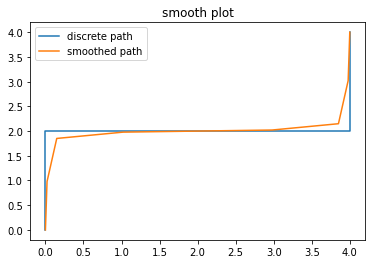

In [5]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

path = [[0, 0], # sample discrete path
        [0, 1],
        [0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [4, 3],
        [4, 4]]

def smooth(path, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001):
    # Make a deep copy of path into newpath
    newpath = deepcopy(path)
    update = tolerance # based on this we will stop the gradient descent
    while update>=tolerance:
        update = 0.0
        for i in range(1,len(newpath)-1):
            for j in range(len(newpath[0])):
                temp = newpath[i][j]
                newpath[i][j] += weight_data * (path[i][j] - newpath[i][j]) +\
                    weight_smooth * (newpath[i-1][j] + newpath[i+1][j] - 2.0 * newpath[i][j])
                update += abs(temp-newpath[i][j])
    
    return newpath

path_arr = np.array(path)
smooth_path = np.array(smooth(path))

plt.plot(path_arr[:,0],path_arr[:,1],label='discrete path')
plt.plot(smooth_path[:,0],smooth_path[:,1],label='smoothed path')
plt.title('smooth plot')
plt.legend()
plt.show()

From the above output we can see that we convert the discrete values to continuous values except for starting and ending point. Thus we find a path that is suitable for robot motion. However there are some caveats here, whenever there is obstacles in the environment and if we do not consider the obstacles during planning or smoothing, The smooth path can hit the obstacles. So during smoothing or planning the path we have to consider about the obstacles based on our environment of the robot. 

<b>PID control: </b> So we got an optimal path from planner and then applying smoothing to the path we got a smooth path suitable for our robot motion. Now we have to give the robot command to follow the smoothed path. How can we do that? For example, an autonomous car has two steerable wheels(at the front) and two stationary wheels(at the back). We can control the steer such as the car follow the smoothed path. For that purpose we can calculate the cross track error(CTE) (distance between the middle point of the car and the reference trajectory(smoothed path)) and steer in proportion to CTE. This controller is known as P controller. So the steering angle will be -
    
   $$\alpha = -\tau * CTE$$ here $\tau$ is proportional gain. 
    
    
There are some issues involved in doing this. For example, if we change the steer angle in proportion to the CTE then eventually the car will overshoot the reference trajectory and the motion for the car will be something like a sin curve with a very little amplitude. Now consider yourself sitting in that car :p. That will be very unrealistic right? 
    
So now we have to find a way to remove this oscillation. The trick is called PD control. In PD control, the steering angle is not just proportional to the CTE but also to the differential CTE. This means when the car has turned enough to reduce the CTE it won't just go shooting for the X axis but it will notice that it already reducing the error by this differential term. So when the error becomes smaller over time it counter steers and steers up again. This will allow the car to gracefully reach the target trajectory. PD controller uses another control parameter called differential gain. For PD controller the steering action will be- 

   $$\alpha = -\tau_{p} * CTE -\tau_{d} * \frac{d}{dt}CTE$$ here $\tau_{d}$ is proportional gain. 

The differenttial term can be calculated very easily by keeping record of CTE. At time t the differential term will be-

   $$\frac{d}{dt} = \frac{CTE_{t} - CTE_{t-1}}{\Delta t}$$
  
A very common problem that often occurs in robotic is called systemetic bias. Suppose the wheel of the car has some steering drift noise. By that we mean that the control of the wheel has some errors. Then the car will not converge to the trajectory line anymore. It will have a bias problem. It will keep a constant distance from trajectory line because of steering drift noise. To solve this we will use PID controller. 

In PID controller we will notice the CTE over a long period of time and if the CTE does not significantly become low then we will steer more and more with time goes by, so that the car converges to the trajectory line after certain time even with steering drift noise. So the equation is as follows-

   $$\alpha = -\tau_{p} * CTE -\tau_{d} * \frac{d}{dt}CTE -\tau_{i} * \sum CTE $$here $\tau_{i}$ is integration gain.

<img src="images/pid.png" width="400"/>

Following is the code for PID controller implementation. We use similar robot class from Particle filter example.  

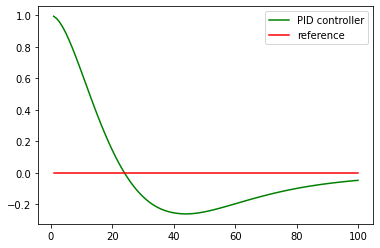

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)
# initialize robot
robot = Robot()
# set initialize position
robot.set(0, 1, 0)

# applyiong PID control on the move function of the robot to control the robot motion
def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    prev_cte = robot.y
    int_cte = 0
    for i in range(n):
        cte = robot.y
        diff_cte = (cte - prev_cte) / speed
        prev_cte = cte
        int_cte += cte
        steer = -tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)
# plotting robot trajectory
plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

So from the equation above we can see that the control gains ($\tau_{d}\tau_{i}\tau_{p}$) are very important constant to choose and the performance depends on these control gains. So how can we come up with a good values for these? There are many hyperparameter optimization techniques. Twiddle (also known as Coordinate Ascent) is one of them. But it is very easy to understand.

Twiddle Algorithm:
<img src="images/twiddle.png" width="500"/>

here the goodness is measured by the CTE by running the move function for a candidate set of parameters. 

## SLAM

SLAM is a very popular technique for doing localization and mapping at the same time as the name suggest SLAM(Simultenious Localization And Mapping). So in the previous section when we learn about localization we consider that we already have the map of the environment. Now we will localize and create the map at the same time using SLAM techniques. Localization is important in creating map. Otherwise if the robot runs into a loop because of some drift error or else the resulted map will be very different then reality. 

There are many version of SLAM algorithm. We will discuss about graph SLAM this is very easy to understand and also very effective. 

To understand this in a simple way let’s assume an initial position of the robot X=0 & Y=0, for this example assume that there is no concern of heading direction & compass. Let’s assume the robot moves to the right in the x-direction by 10, so now the location after motion(X1) in a perfect world would be X1= X0+10 and Y1= 0.

But as we know that the real world is uncertain. So it is better to represent the robot location with gaussian distribution centered around 10 with some uncertainty. So if we put this equation into Gaussian formula we will get the probability distribution of the new location which is as follows- 

$$ p(X_{1}) = \frac{1}{\sqrt{2\pi\sigma^{2}}}*\exp{-\frac{1}{2}*\frac{(X_{1}-X_{0}-10)^{2}}{\sigma^{2}}}$$
$$ p(Y_{1}) = \frac{1}{\sqrt{2\pi\sigma^{2}}}*\exp{-\frac{1}{2}*\frac{(Y_{1}-Y_{0})^{2}}{\sigma^{2}}}$$

The goal is to maximize the likelihood of the position X1 given the position X0 is (0,0).The product of these two Gaussian is now our constraint. So, what GRAPH SLAM does is it defines the probabilities using a sequence of such constraints. 

GRAPH SLAM collects it’s initial location which is (0,0) initially (Initial Constraints) then lots of relative constraints that relate each robot pose to the previous robot pose( Relative Motion Constraints). As an example, let’s use landmarks which can be seen by the robot at various locations which would be Relative Measurement Constraints(every time a robot sees a landmark).

These constraints altogether find the most likely configuration of the robot path along with the location of landmark and that is the mapping process.

In this algorithm we maintain one matrix called $\Omega$ and another vector of distances. Then we move the robot and add the corresponding constraint in the matrix (This is based on total probability theory). We also multiply the constrain with the uncertainty term $\frac{1}{\sigma^{2}}$ before adding it to the matrix. It simply increase the confidence of the constrain. At the end we take the inverse of the matrix and then multiply with the vecto and thus we get a vector of all possible location of the robot and Landmarks. The algorithm is demostrated in the following figure. 

<table>
       <tr>
            <th><img src="images/slam.png" width="400"/></th>
            <th><img src="images/slam1.png" width="400"/></th>
       </tr>
</table>

The above simple technique has a very great disadvantage though. If you notice the matrix, it has one column and row for every single step the robot takes. So with time this matrix grow very large and eventually it will stop working. The solution for this is online SLAM. What we do in online SLAM is we keep only the last position information and landmark information (landmarks are fixed) in the matrix. At first we expand the matrix with one row and column to calculate the values in the same way. After calculating we discard the previous step information and keep only the latest step information. Before discarding we do some calculation to include the previous step information inside the remaining matrix. Online SLAM is explained in the following figure: 

<img src="images/online_slam.png" width="400"/>

Thus the course ends here. Some sample projects that applies these theories in practical can be found in my github profile. (Link will be given here soon)